In [27]:
%matplotlib widget
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import morph_geom_lib as mgl
import models.shallow_depth_morph_models as sdmodels

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

rc('animation', html='html5')

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['default'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TVD-WENO Scheme

https://www.ams.org/journals/mcom/1998-67-221/S0025-5718-98-00913-2/S0025-5718-98-00913-2.pdf

The TVD second order Runge-Kutta method we consider is the one given in
[12]:
$$u^{(1)} = u^n + ∆tL(u^n)$$,
$$u^{n+1} = 0.5u^n + 0.5u^{(1)} + 1/2∆tL(u^{(1)})$$


Z: 87
0.01569138276553106


Text(0, 0.5, 'z (m)')

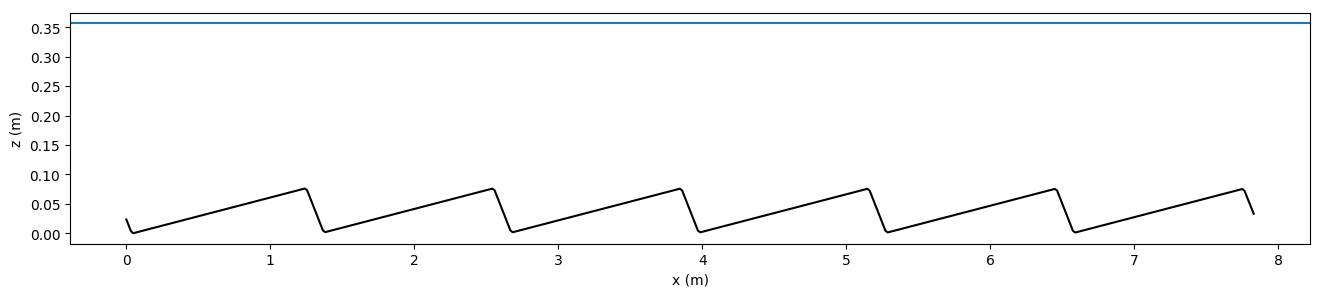

In [19]:
profile_folder = '/pymorph/notebooks/Paper_3/flume_profile_smoothed_v002.txt'
xc, z0 = mgl.readQueensFlume(profile_folder,1)

fig = plt.figure(figsize=(16, 3))
#plt.plot(xc,z0,'b')

dunes = 6

xsaw = np.linspace(0, 1,500)
simTime = 60*10 # Runtime in seconds
dt = 0.5 # Time step size (s)

zsaw = 0.076*(signal.sawtooth(2*dunes*np.pi * xsaw) + 1.)/2
xsaw = xsaw*xc.max()*dunes*0.5
#plt.plot(xsaw,zsaw)


dx = xsaw[1]-xsaw[0]
znew, iterations1 = avalanche_model(dx,xsaw, zsaw, adjustment_angle=28.)
# Now flip it to run in reverse
zflip = np.flip(znew, axis=0)
zflip, iterations1 = avalanche_model(dx,xsaw, zflip, adjustment_angle=28.)
znew = np.flip(zflip, axis=0)

znew = (znew - np.min(znew))/np.ptp(znew)
znew = znew*0.076

plt.plot(xsaw,znew,'-',color='k')
plt.axhline(0.357)
print(dx)
plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [64]:
model = sdmodels.ShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = xsaw.copy()
zc = znew.copy()
x0 = xsaw.copy()
z0 = znew.copy()
nx = len(xc)

model.setup_domain(xc, zc, dx)

#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.247

model.flow_boundary_conditions(q32cm, sOut32)

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
Mannings = 0.048
Slope = 1.26/1000.

model.setup_hydro_model(Mannings, Slope)


#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------

morph_model = sdmodels.EulerWenoModel()

model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 1.*60       # Runtime in seconds
dt = 1                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*0.5


model.run(simTime, dt, extractionTime, None)



 Starting simulation....
Number of time steps: 1.0 mins
Grid dx = 0.01569138276553106
Grid nx = 500
Initializing hydrodynamic model...
2019-05-12 03:26:03,265 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-12 03:26:23,154 INFO CLAW: Solution 1 computed for time t=300.000000
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Max qbedload = 6.167158807791272e-06
2019-05-12 03:26:23,709 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-12 03:26:24,206 INFO CLAW: Solution 1 computed for time t=10.000000
2019-05-12 03:26:24,239 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-12 03:26:24,947 INFO CLAW: Solution 1 computed for time t=10.000000
2019-05-12 03:26:24,995 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-12 03:26:25,690 INFO CLAW: Solution 1 computed for time t=10.000000
2019-05-12 03:26:25,828 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-12 03:26:26,469 INFO CLAW: Solu

(array([0.02857325, 0.01953127, 0.0106018 , 0.00158325, 0.00062047,
        0.00184197, 0.00283185, 0.00381894, 0.00481645, 0.0058135 ,
        0.00681033, 0.00780714, 0.00880389, 0.00980058, 0.0107972 ,
        0.01179377, 0.01279026, 0.01378669, 0.01478304, 0.01577932,
        0.01677553, 0.01777166, 0.0187677 , 0.01976367, 0.02075955,
        0.02175534, 0.02275104, 0.02374664, 0.02474216, 0.02573757,
        0.02673288, 0.0277281 , 0.0287232 , 0.0297182 , 0.03071308,
        0.03170784, 0.03270247, 0.03369696, 0.03469132, 0.03568551,
        0.03667955, 0.03767343, 0.03866715, 0.03966072, 0.04065415,
        0.04164745, 0.04264062, 0.04363366, 0.04462658, 0.04561935,
        0.04661197, 0.0476044 , 0.04859661, 0.04958858, 0.05058026,
        0.05157167, 0.05256281, 0.0535537 , 0.05454439, 0.05553491,
        0.05652531, 0.0575156 , 0.0585058 , 0.0594959 , 0.06048587,
        0.06147568, 0.06246523, 0.06345442, 0.06444315, 0.06543136,
        0.06641899, 0.06740606, 0.06839262, 0.06

In [54]:
len(h)

500

In [55]:
len(q)

500

In [56]:
sOut

NameError: name 'sOut' is not defined

In [57]:
len(q)

500